In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

2025-06-05 08:07:16.776130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 08:07:16.924152: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 08:07:17.026423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749096437.118927    5185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749096437.144296    5185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749096437.351829    5185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
PREPARED_DATASET = 'dataset/prepared/'

In [3]:
def load_raw_data(file_name):
    input_path = os.path.join(PREPARED_DATASET, file_name)
    df = pd.read_csv(input_path, sep="|", names=["x", "y"])
    x = df["x"].values
    y = df["y"].values
    return x, y

In [4]:
def normalize_data(x: list[float], y: list[float]):
    # нормализация по X и Y
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    return x_norm, y_norm

In [80]:
def create_model(input_length):
    # для сегментации будем использовать несколько слоев
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(input_length, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [91]:
def predict_key_points(model, x: list[float], y: list[float], max_regions=2):
    X = y.reshape(1, -1, 1)
    print(X.shape[1])
    mask = model.predict(X)[0]

    threshold = 0.1
    key_indices = [i for i in range(len(mask)) if mask[i] > threshold]

    grouped_regions = []
    current_region = []
    for i in range(len(key_indices)):
        if not current_region or key_indices[i] - key_indices[i - 1] <= 10:
            current_region.append(key_indices[i])
        else:
            grouped_regions.append(current_region)
            current_region = [key_indices[i]]
    if current_region:
        grouped_regions.append(current_region)

    top_regions = sorted(grouped_regions, key=lambda r: len(r), reverse=True)[:max_regions]
    top_centers = [int(np.mean(region)) for region in top_regions]

    plt.figure(figsize=(12, 4))
    plt.plot(x, y, label="Signal", color="black")
    for pt in top_centers:
        plt.axvline(x[pt], color="pink", linestyle="--", linewidth=2, label="Key Point")
    plt.title(f"Key points in norm")
    plt.legend()
    plt.show()

Epoch 1/20


/home/marat/venv/jupyter-vim/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6930
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.6826
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.6616
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.6257
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.5729
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5043
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4251
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3436
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2681
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2037
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1512
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1096
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0774
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0525
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0333
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/

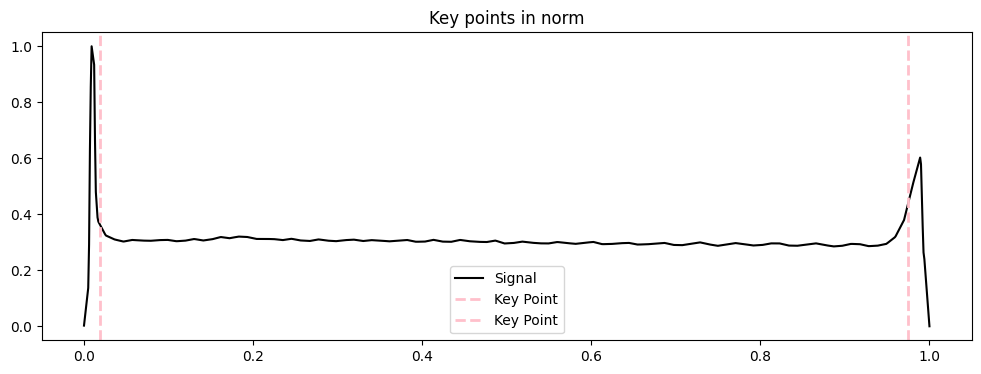

In [92]:
x_raw, y_raw = load_raw_data("norm.csv")
x, y = normalize_data(x_raw, y_raw)

X_signals = []
Y_masks = []

end1 = len(x) // 4
end2 = end1 * 3

x2 = x[end1: end2+1]
y2 = y[end1: end2+1]

mean = np.mean(y2)
std = np.std(y2)

X_signals.append(y)

mask = (y > mean + 3 * std).astype(float)
Y_masks.append(mask)
#print(Y_masks)

X_signals = np.array(X_signals)[..., np.newaxis]
Y_masks = np.array(Y_masks)[..., np.newaxis]

#print(X_signals.shape[1])
#print(X_signals)
#print(Y_masks)

model = create_model(X_signals.shape[1])
#model.summary()

model.fit(X_signals, Y_masks, epochs=20, batch_size=4)

predict_key_points(model, x, y)
